In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1

def sharpe_ratio(daily_ret: np.ndarray) -> float:
    if daily_ret.std() == 0:
        return np.nan
    return np.sqrt(252) * daily_ret.mean() / daily_ret.std()

def max_drawdown(equity: np.ndarray) -> float:
    peak = np.maximum.accumulate(equity)
    drawdown = equity / peak - 1.0
    return drawdown.min()

In [2]:
spy = pd.read_parquet("../data/processed/spy_daily.parquet")
spy["date"] = pd.to_datetime(spy["date"])
spy["year"] = spy["date"].dt.year

spy.head()


,date,open,high,low,close,adj_close,volume,year
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,85.027946,118944600,2010
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,85.253067,111579900,2010
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,85.313049,116074400,2010
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,85.673180,131091100,2010
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,85.958290,126402800,2010


In [3]:
results = []
daily_all = []

years = sorted(spy["year"].unique())

for test_year in years:
    test = spy[spy["year"] == test_year]

    if len(test) == 0:
        continue

    out = run_meanrev_strategy_v1(
        test,
        entry_ret_5d_threshold=-0.02,
        hold_days=3,
        max_vol_annual=0.40,
        cost_per_side_bps=5.0,
    )

    equity = (1 + out["raw_ret"]).cumprod().values

    summary = {
        "year": test_year,
        "sharpe": sharpe_ratio(out["raw_ret"].values),
        "total_return": equity[-1] - 1.0,
        "max_drawdown": max_drawdown(equity),
        "days_in_market": (out["position"] > 0).mean(),
    }

    results.append(summary)
    daily_all.append(out.assign(year=test_year))


In [4]:
meanrev_summary = pd.DataFrame(results)
meanrev_summary


,year,sharpe,total_return,max_drawdown,days_in_market
0,2010,0.113950,0.006525,-0.103407,0.214286
1,2011,-0.300998,-0.057268,-0.157117,0.226190
2,2012,1.615649,0.099879,-0.065192,0.176000
3,2013,2.005411,0.084812,-0.015978,0.095238
4,2014,0.933859,0.049260,-0.030756,0.119048
5,2015,0.447055,0.036987,-0.082334,0.130952
6,2016,1.885103,0.097324,-0.027568,0.083333
7,2017,NaN,0.000000,0.000000,0.000000
8,2018,-0.448709,-0.062704,-0.120699,0.227092
9,2019,0.841816,0.053869,-0.030558,0.107143


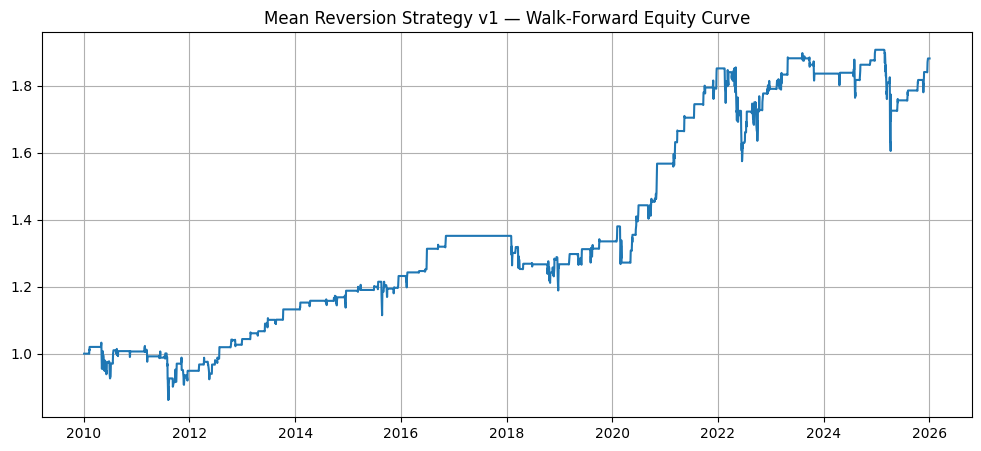

In [5]:
meanrev_daily = pd.concat(daily_all).sort_values("date")
equity = (1 + meanrev_daily["raw_ret"]).cumprod()

plt.figure(figsize=(12,5))
plt.plot(meanrev_daily["date"], equity)
plt.title("Mean Reversion Strategy v1 — Walk-Forward Equity Curve")
plt.grid(True)
plt.show()
